# 正则化的多项式线性回归

> - 魏宇翔
> - 汪政
> - 冯宇霄
> - 涂欣宇

## 介绍

在这个 notebook 里面，我们调用了我们实现的**正则化的多项式线性回归**模型：

- 多元的线性回归模型
- 通过传入参数 `basis function` 实现多项式线性回归（包括多项式回归）
- 引入了正则化，可以通过调整正则化参数 `reg_lambda` 进行实验

我们针对了一组带有随机化生成的数据集进行实验，可以在该笔记中自由尝试模型参数～

## 实验过程

首先，安装需要的依赖库，并添加 `PYTHONPATH`

In [1]:
!pip install -r ../requirements.txt || pip3 install -r ../requirements.txt

import sys
sys.path.append("..")

Could not build wheels for numpy, since package 'wheel' is not installed.
Could not build wheels for matplotlib, since package 'wheel' is not installed.
Could not build wheels for pandas, since package 'wheel' is not installed.
Could not build wheels for python-dateutil, since package 'wheel' is not installed.
Could not build wheels for cycler, since package 'wheel' is not installed.
Could not build wheels for pyparsing, since package 'wheel' is not installed.
Could not build wheels for kiwisolver, since package 'wheel' is not installed.
Could not build wheels for pytz, since package 'wheel' is not installed.
Could not build wheels for six, since package 'wheel' is not installed.


其次，引入所需要的第三方库以及我们的模型

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from linear_models.regression_model import RegularizedLinearRegression

自定义数据类型 `Data`，这是正弦函数添加高斯噪声的结果，数学表达式如下：

$y = \sin(2\pi x) + \mathcal N(x \mid 0, 0.3),\ x \in [0, 1)$

同时我们定义了一个基本函数，实现多项式线性回归，从而得到更强大的模型。它的表达形式如下：

$\phi(x) = \begin{bmatrix}1\\x\\x^2\\\vdots\\x^{10}\end{bmatrix}$

In [3]:
class Data:
    _range = np.arange(0, 1, 0.1)

    # 在第一列补充 1
    X = np.concatenate((np.ones(_range.shape[0]).reshape(-1, 1), _range.reshape(-1, 1)), axis=1)
    # sin(x) 以及随机噪声
    y = np.sin(2 * np.pi * _range) + np.random.normal(0, 0.3, _range.size)

    @staticmethod
    # 多项式回归，一个十次多项式
    def basis_func(x):
        return np.array([
            1,
            x[1],
            x[1] ** 2,
            x[1] ** 3,
            x[1] ** 4,
            x[1] ** 5,
            x[1] ** 7,
            x[1] ** 8,
            x[1] ** 9,
            x[1] ** 10,
        ])

这个函数能够绘出我们的实际数据集，也会在后续代码中使用：

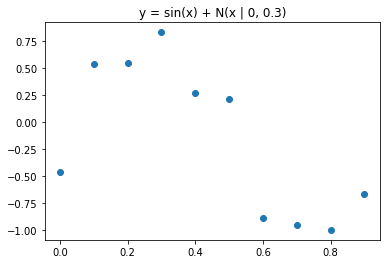

In [4]:
def plot_truth():
    plt.scatter(Data.X[:, 1], Data.y, label="Ground Truth")

plot_truth()
plt.title("y = sin(x) + N(x | 0, 0.3)")
plt.show()

初始化我们的模型对象，传入相应参数，观察模型的梯度和损失：

In [5]:
model = RegularizedLinearRegression(
    training_set=Data.X,
    target_set=Data.y,
    basis_func=Data.basis_func,
    reg_lambda=0
)

print("梯度:", model.gradient())
print("损失:", model.cost())

梯度: [0.15578913 0.44048353 0.49158227 0.47280498 0.43853241 0.40315057
 0.34297545 0.31907026 0.29877621 0.28155885]
损失: 0.23752841398755664


In [6]:
# 一个工具函数，可以画出预测值
def plot_prediction(input_data, prediction, title):
    plt.plot(input_data, prediction, "r")
    plt.title(title)

首先，让正则化参数 $\lambda = 0$，故意让模型过拟合观察结果。这里直接使用了**正规方程**的方法直接求到闭式解。之后会实验梯度下降求解。

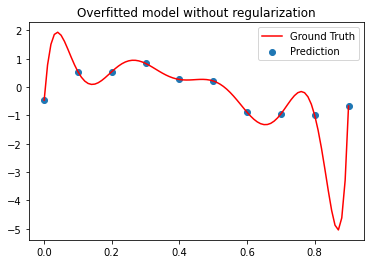

In [7]:
# 测试结果的范围，由于原始数据最后是0.9这个点，所以这里的范围这样子写
input_range = np.arange(0, 0.91, 0.01)

# 正则化参数 lambda
model.reg_lambda = 0.0
model.learn_by_normal_equation()
overfit_prediction = np.array([model.prediction(np.append(1, x)) for x in input_range])

# 画出真实结果以及预测结果
plot_truth()
plot_prediction(input_range, overfit_prediction, "Overfitted model without regularization")
plt.legend(["Ground Truth", "Prediction"])
plt.show()

现在令正则化参数为 $\lambda = 0.01$，可以发现模型没有过拟合，是正常的效果。

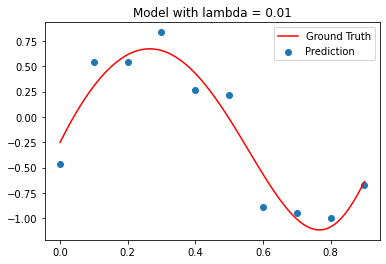

In [8]:
model.reg_lambda = 0.01
model.learn_by_normal_equation()
good_prediction = np.array([model.prediction(np.append(1, x)) for x in input_range])

plot_truth()
plot_prediction(input_range, good_prediction, "Model with lambda = {}".format(model.reg_lambda))
plt.legend(["Ground Truth", "Prediction"])
plt.show()

最后实验欠拟合结果，将正则化参数变为 $\lambda = 10$。

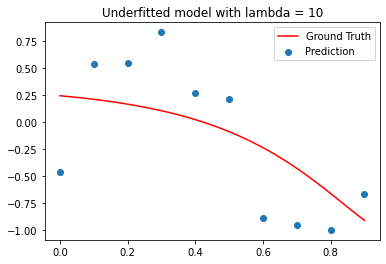

In [9]:
model.reg_lambda = 10
model.learn_by_normal_equation()
underfit_prediction = np.array([model.prediction(np.append(1, x)) for x in input_range])

plot_truth()
plot_prediction(input_range, underfit_prediction, "Underfitted model with lambda = {}".format(model.reg_lambda))
plt.legend(["Ground Truth", "Prediction"])
plt.show()

这里利用梯度下降算法进行实验，同时绘出代价函数的变化情况

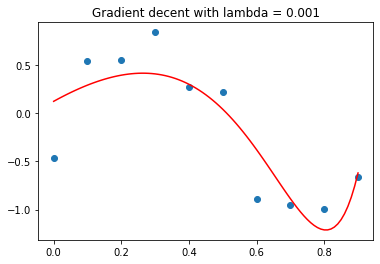

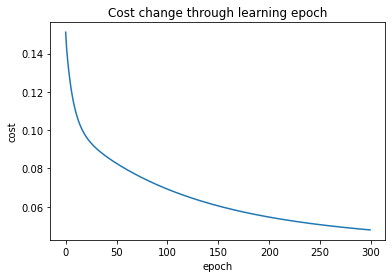

In [10]:
# 需要重置一下参数，否则在实验过程中如果learning_rate太大会让参数爆炸
model.params = np.zeros(model.params.size)
# 设置正则化参数
model.reg_lambda = 0.001
# 传入梯度下降的学习率以及迭代次数，学习率过大会导致代价函数增加
model.learn_by_gradient_decent(learning_rate=0.1, epochs=300)
gradient_learn_prediction = np.array([model.prediction(np.append(1, x)) for x in input_range])

plot_truth()
plot_prediction(input_range, gradient_learn_prediction,
                "Gradient decent with lambda = {}".format(model.reg_lambda))
plt.show()

# 展示代价函数在训练过程中的变化情况
plt.plot(model.cost_history)
plt.xlabel("epoch")
plt.ylabel("cost")
plt.title("Cost change through learning epoch")
plt.show()
